In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset

In [2]:
im_dir = '/Volumes/Tatum_SSD-1/Grad_school/m2py/Morphology_labels/OFET_morph_maps/Default_params/'

im_files = os.listdir(im_dir)
print(len(im_files))
# print(im_files)

111


Below is a set of 30 substrates and devices that comprise the test set for the tabular data. We want to make sure that the test set for this network is also comprised of samples from this set, to make sure that all models are comparable. Because there is so little image data, we will only select 10 devices for our test set

In [3]:
test_set_key_dict = {
    0 : {'temp' : 125, 'time' : 10, 'sub' : 3, 'dev' : 1},
    1 : {'temp' : 125, 'time' : 5, 'sub' : 1, 'dev' : 1},
    2 : {'temp' : 125, 'time' : 5, 'sub' : 2, 'dev' : 2},
    3 : {'temp' : 150, 'time' : 30, 'sub' : 7, 'dev' : 2},
    4 : {'temp' : 100, 'time' : 10, 'sub' : 4, 'dev' : 3},
    5 : {'temp' : 75, 'time' : 10, 'sub' : 4, 'dev' : 1},
    6 : {'temp' : 125, 'time' : 10, 'sub' : 4, 'dev' : 2},
    7 : {'temp' : 100, 'time' : 15, 'sub' : 6, 'dev' : 4},
    8 : {'temp' : 100, 'time' : 10, 'sub' : 3, 'dev' : 5},
    9 : {'temp' : 125, 'time' : 5, 'sub' : 2, 'dev' : 1},
}

print(len(test_set_key_dict))
test_set_key_df = pd.DataFrame.from_dict(test_set_key_dict, orient = 'index')
test_set_key_df.head()

10


,temp,time,sub,dev
0,125,10,3,1
1,125,5,1,1
2,125,5,2,2
3,150,30,7,2
4,100,10,4,3


In [4]:
im_dict = {}
label_dict = {}
idx = 0
for i, fl in enumerate(im_files[1:]):
#     print(i)
    
    if fl[-1] == 'v':
        pass
    
    elif fl[-1] == 'y':
        anl_temp = 0
        anl_time = 0
        sub = 0
        dev = 0

        if i < len(im_files):
            seg1_dir = im_dir+im_files[i]
            seg2_dir = im_dir+im_files[i+1]
            
            if im_files[i][:-6] == im_files[i+1][:-6]:
#                 print(f'saving file: #{i}: {fl}')
                
                seg1_dir = im_dir+im_files[i]
                seg2_dir = im_dir+im_files[i+1]
                
                seg1 = np.load(seg1_dir)
                seg2 = np.load(seg2_dir)
                
                sample = np.stack([seg1, seg2], axis = -1)
                sample = sample.astype(np.double)
                
                im_dict[idx] = sample

            
                #extract temp, time, sub, dev from filename
                temp_stop_indx = fl.index('C')
                anl_temp = int(fl[:temp_stop_indx])

                time_start_indx = temp_stop_indx+2
                time_stop_indx = fl.index('m')
                time_stop_indx = time_stop_indx
                anl_time = fl[time_start_indx:time_stop_indx]
                anl_time = int(anl_time)

                s_idx = fl.index('n')+2
                d_idx = fl.index('n')+4

                sub = fl[s_idx]
                dev = fl[d_idx]
                    
                #assign entry identifiers to label key
                label_dict[idx] = {'Anneal_time' : int(anl_time), 'Anneal_temp' : int(anl_temp),
                                 'Substrate' : int(sub), 'Device': int(dev)}
                
                idx += 1
                

            else:
                pass
        else:
#             print('end of loop')
            pass
    else:
#         print('Non-.npy file')
        pass
label_df = pd.DataFrame.from_dict(label_dict, orient = 'index')
print(len(label_dict))
print(len(im_dict))

label_df.to_excel('/Volumes/Tatum_SSD-1/Grad_school/m2py/Morphology_labels/OFET_morph_maps/im_key.xlsx')

37
37


In [5]:
test_sample_idxs = []

#find the indexes of the rows (samples) that match our test set's identifiers
for i, row in test_set_key_df.iterrows():
#     print(row)
#     print(row[0])
    #query for sample labels that = test set identifiers
    time_matches = label_df[label_df['Anneal_temp'] == row[0]]
#     print(len(time_matches))
    temp_matches = time_matches.query('Anneal_time == @row[1]')
#     print(len(temp_matches))
    sub_matches = temp_matches.query('Substrate == @row[2]')
#     print(len(sub_matches))
    matches = sub_matches.query('Device == @row[3]')
#     print(len(matches))

#     matches = label_df.query('Anneal_time == @row[0]' &
#                                   'Anneal_temp == @row[1]' &
#                                   'Substrate == @row[2]' &
#                                   'Device == @row[3]')
    
    if len(matches) > 0:
        #append index of match to test_sample_idxs
#         print(f"matches: {matches}")
#         print(f"number of matches: {len(matches)}")
        match_idxs = matches.index[:].tolist()
        test_sample_idxs.append(match_idxs[0])
    
    else:
        pass

    
test_sample_idxs.sort()
test_sample_idxs = list(set(test_sample_idxs))
print(len(test_sample_idxs))
print(test_sample_idxs)

10
[2, 4, 5, 12, 13, 20, 22, 23, 26, 31]


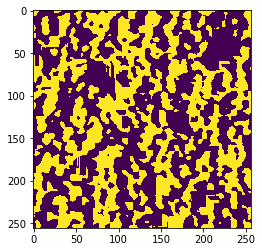

In [6]:
#using the test set indexes, extract our test set from the population

test_data = {}

for i, idx in enumerate(test_sample_idxs):
    test_data[i] = im_dict[idx]

plt.imshow(test_data[0][:,:,0])

In [7]:
train_data = {}
train_sample_idxs = []

for key, value in im_dict.items():
    if key in test_sample_idxs:
        pass
    else:
        train_data[key] = value
        train_sample_idxs.append(key)
        
print(len(train_data))
print(train_sample_idxs)
print(len(test_data))
print(test_sample_idxs)

27
[0, 1, 3, 6, 7, 8, 9, 10, 11, 14, 15, 16, 17, 18, 19, 21, 24, 25, 27, 28, 29, 30, 32, 33, 34, 35, 36]
10
[2, 4, 5, 12, 13, 20, 22, 23, 26, 31]


In [8]:
sample_fls = []

for fl in im_files:
    if fl[-1] == 'e':
        pass
    elif fl[-1] == 'v':
        pass
    elif fl[-5] == '2':
        pass
    else:
        sample_fls.append(fl[:-9])
        
print(len(sample_fls))
print(sample_fls)

37
['100C_10min_3_1', '100C_10min_3_3', '100C_10min_3_5-1', '100C_10min_3_5', '100C_10min_4_3', '100C_15min_6_4-1', '100C_15min_6_5', '100C_30min_8_1', '100C_30min_8_2', '100C_30min_8_5', '100C_5min_2_1', '100C_5min_2_2', '125C_10min_3_1', '125C_10min_4_2', '125C_10min_4_5', '125C_15min_5_3', '125C_15min_5_4', '125C_15min_6_5', '125C_30min_7_3', '125C_30min_8_1', '125C_5min_1_1', '125C_5min_1_4', '125C_5min_2_1', '125C_5min_2_2-1', '125C_5min_2_3', '150C_30min_7_1', '150C_30min_7_2', '150C_30min_7_4', '150C_30min_8_3', '150C_30min_8_4', '150C_30min_8_5', '75C_10min_4_1', '75C_10min_4_2', '75C_15min_6_3', '75C_30min_8_2', '75C_30min_8_5', '75C_5min_1_2']


Now that we have two dictionaries with our image data, and a sample key to link each index to a filename, we can now save them into separate folders to build pytorch dataloaders directly in the notebook

In [9]:
for i, im in im_dict.items():
    if i in train_sample_idxs:
        np.save('/Volumes/Tatum_SSD-1/Grad_school/m2py/Morphology_labels/OFET_morph_maps/train_set/'+sample_fls[i]+'_labels.npy', im)
    elif i in test_sample_idxs:
        np.save('/Volumes/Tatum_SSD-1/Grad_school/m2py/Morphology_labels/OFET_morph_maps/test_set/'+sample_fls[i]+'_labels.npy', im)
    else:
        print('error')

## Now that the data is partitioned and saved for consistency:

It's time to make sure those files can be loaded and used to train PyTorch models

In [25]:
class local_OPV_ImDataset(torch.utils.data.Dataset):
    """
    This class takes in a filepath pointing to a directory of images and labels,
    and loads them into a custom dataset class that inherets from PyTorch. 
    """
    def __init__(self, filepath):
        super(local_OPV_ImDataset).__init__()
        
        files = os.listdir(filepath)
        
        self.im_dict = {}
        label_dict = {}
        for i, fl in enumerate(files):
#             print(fl)
            anl_temp = 0
            anl_time = 0
            sub = 0
            dev = 0

            if fl[-1] == '/':
                pass
            elif fl[-1] == 'e':
                pass

            else:
                im = np.load(filepath+fl)

                im_index = len(self.im_dict)
                self.im_dict[im_index] = im

                if 'NOANNEAL' in fl:
                    #time = temp = 0
                    anl_temp = 0
                    anl_time = 0

                    #extract sub and dev
                    s_idx = fl.index('S')+1
                    d_idx = fl.index('D')+1

                    sub = fl[s_idx]
                    dev = fl[d_idx]

                elif 'postexam' in fl:
                    #extract temp, time, sub, dev from filename
                    temp_stop_indx = fl.index('C')
                    temp_start_indx = 0
                    anl_temp = int(fl[temp_start_indx:temp_stop_indx])

                    time_start_indx = temp_stop_indx+2
                    time_stop_indx = fl.index('m')
                    time_stop_indx = time_stop_indx
                    anl_time = fl[time_start_indx:time_stop_indx]
                    anl_time = int(anl_time)

                    sub = 4
                    dev = 6

                elif fl[-1] != '/':
                    #extract temp, time, sub, dev from filename
                    temp_stop_indx = fl.index('C')
                    temp_start_indx = 0
                    anl_temp = int(fl[temp_start_indx:temp_stop_indx])

                    time_start_indx = temp_stop_indx+2
                    time_stop_indx = fl.index('m')
                    time_stop_indx = time_stop_indx
                    anl_time = fl[time_start_indx:time_stop_indx]
                    anl_time = int(anl_time)

                    s_idx = fl.index('b')+1
                    d_idx = fl.index('v')+1

                    sub = fl[s_idx]
                    dev = fl[d_idx]

                #assign entry identifiers to label key
                label_dict[i] = {'Anneal_time' : int(anl_time), 'Anneal_temp' : int(anl_temp),
                                         'Substrate' : int(sub), 'Device': int(dev)}

        self.im_labels = pd.DataFrame.from_dict(label_dict, orient = 'index')
        
        
    def __len__(self):
        return len(self.im_dict)

    
    def __getitem__(self, key):
        
        self.im_tensor = self.convert_im_to_tensors(self.im_dict[key])
        self.label_tensor = self.convert_label_to_tensors(self.im_labels.iloc[key].tolist())
        
        return self.im_tensor, self.label_tensor
    
    
    def convert_im_to_tensors(self, im):
        
        im_tensor = torch.from_numpy(im).float()
        im_tensor = im_tensor.view(2, 256, 256)
        
        return im_tensor
        
        
    def convert_label_to_tensors(self, label_df):
        label_tensor =  torch.tensor(label_df).float()
        
        return label_tensor

In [26]:
test_set = local_OPV_ImDataset('/Volumes/Tatum_SSD-1/Grad_School/m2py/Morphology_labels/OPV_morph_maps/train_set/')

In [27]:
test_loader = torch.utils.data.DataLoader(test_set)

In [28]:
for im, label in test_loader:
    print(label)
    print(im)

tensor([[ 15., 100.,   4.,   2.]])
tensor([[[[  1., 160.,   1.,  ..., 636.,   1.,  68.],
          [  1.,  68.,   1.,  ...,   1.,   1.,   1.],
          [  1., 160.,   1.,  ..., 636.,   1.,  68.],
          ...,
          [  1.,   1.,   1.,  ...,   0.,   1.,   0.],
          [  1.,  60.,   1.,  ...,  88.,   1.,   1.],
          [  1.,   1.,   1.,  ...,   0.,   1.,   0.]],

         [[  1.,  60.,   3.,  ...,  88.,   1.,   1.],
          [  1.,   1.,   1.,  ...,   0.,   3.,   0.],
          [  2.,  94.,   3.,  ...,  88.,   3.,  88.],
          ...,
          [  2., 154.,   1.,  ...,   2.,   1.,   2.],
          [  1.,  71.,   1.,  ..., 154.,   2., 154.],
          [  1., 113.,   1.,  ...,   2.,   1.,   2.]]]])
tensor([[ 30., 100.,   7.,   4.]])
tensor([[[[  1., 219.,   1.,  ..., 498.,   2., 498.],
          [  2., 498.,   2.,  ..., 150.,   1.,   0.],
          [  1., 219.,   1.,  ..., 498.,   2., 498.],
          ...,
          [  2., 402.,   1.,  ..., 291.,   1.,  13.],
          [  1.,